In [45]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from astropy.io import fits
from photutils import make_source_mask
from astropy.stats import sigma_clipped_stats
from PIL import Image

In [2]:
catalog_loc = 'catalogs/illustris_galaxies.csv'
df = pd.read_csv(catalog_loc)

In [3]:
def get_catalog_images(df, n_samples):
    images = []
    for _, subject in df.sample(n_samples).iterrows():
        images.append(fits.getdata(subject['fits_loc']))
    return images

In [4]:
raw_images = get_catalog_images(df, 100)

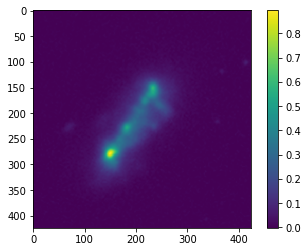

In [5]:
plt.imshow(raw_images[0])
plt.colorbar()

In [6]:
def show_images(images):
    fig, (axes_upper, axes_lower) = plt.subplots(nrows=2, ncols=8, figsize=(24, 5))
    for image_n, ax in enumerate(axes_upper):
        ax.imshow(images[image_n])
    for image_n, ax in enumerate(axes_lower):
        ax.hist(np.ravel(images[image_n]))
    fig.tight_layout()

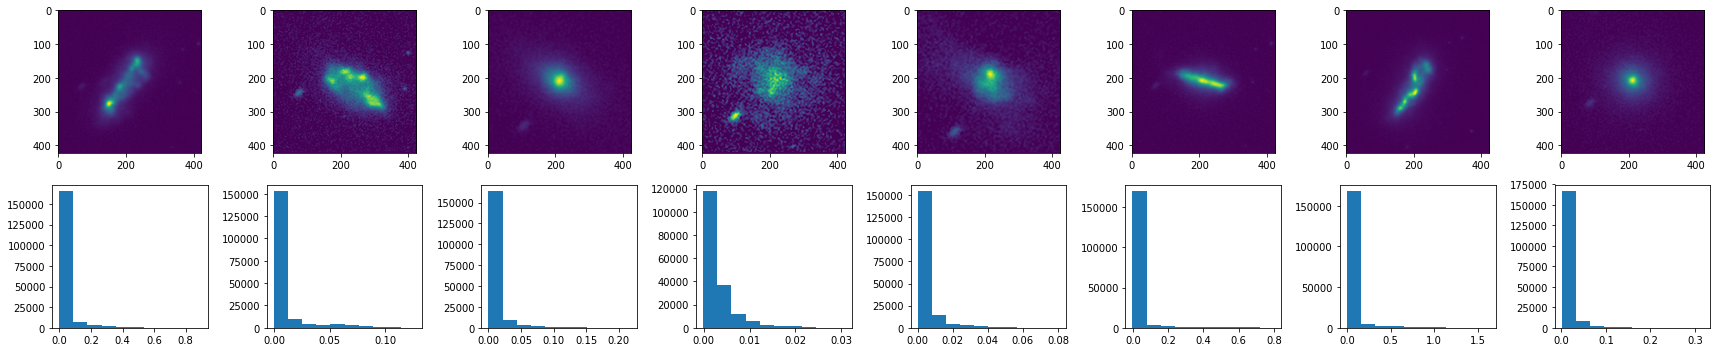

In [7]:
show_images(raw_images)

In [8]:
def estimate_background(im):
    mask = make_source_mask(im, snr=2, npixels=5, dilate_size=11)
    mean, median, std = sigma_clipped_stats(im, sigma=3.0, mask=mask)
    return mean, std

In [9]:
estimate_background(raw_images[0])

(0.002543874120877554, 0.0034976845810181633)

In [10]:
backgrounds = list(map(lambda x: estimate_background(x), raw_images))

In [11]:
background_means = np.array(backgrounds)[:, 0]
background_stds = np.array(backgrounds)[:, 1]

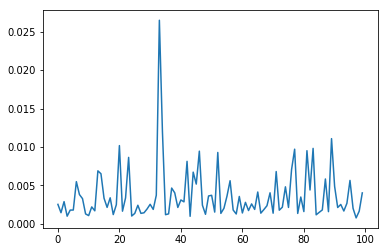

In [12]:
plt.plot(background_means)

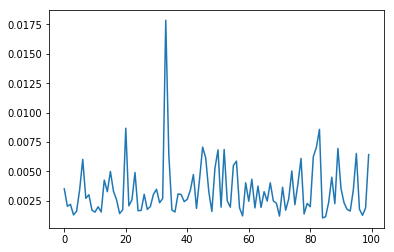

In [13]:
plt.plot(background_stds)

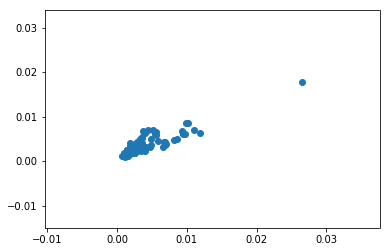

In [14]:
plt.scatter(background_means, background_stds)

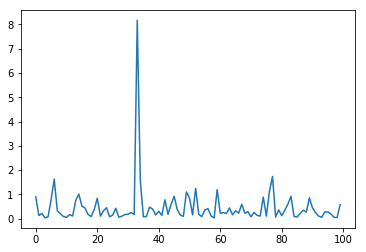

In [15]:
maxima = np.array(list((map(lambda x: np.max(x), raw_images))))
plt.plot(maxima[maxima < 100])  # one outlier

In [16]:
# rescaled_images = list(map(lambda x: np.clip(x, a_min=0, a_max=None), raw_images))
masks = list(map(lambda x: make_source_mask(x, snr=1.5, npixels=5, dilate_size=40), raw_images[:10]))
masked_images = np.array(raw_images[:10]) *  np.array(masks)

In [70]:
def get_image_mask(img):
    return make_source_mask(img, snr=2, npixels=5, dilate_size=11)

def mask_background(img):
    return img * get_image_mask(img)

def clip_img(img):
    source_img = mask_background(img)  # also masks
    return np.clip(img, a_min=0, a_max=source_img.mean() + source_img.std() * 8)

def normalise(img):
    return matplotlib.colors.Normalize(vmin=None, vmax=None, clip=False)(img)

def preprocess_img(img):
    return normalise(np.sqrt(clip_img(img)))

In [71]:
rescaled_images = list(map(preprocess_img, raw_images[:10]))

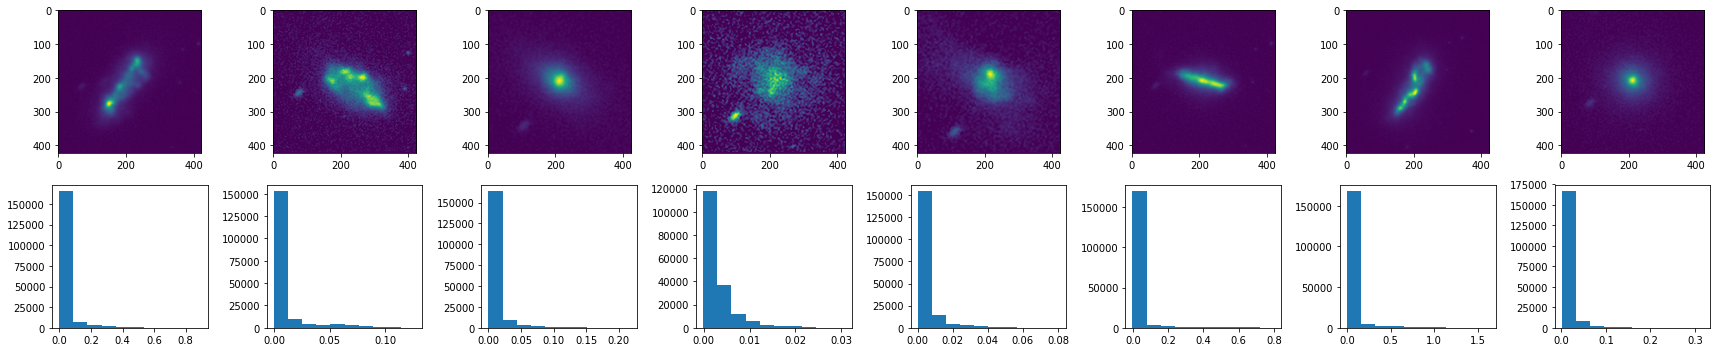

In [73]:
show_images(raw_images)

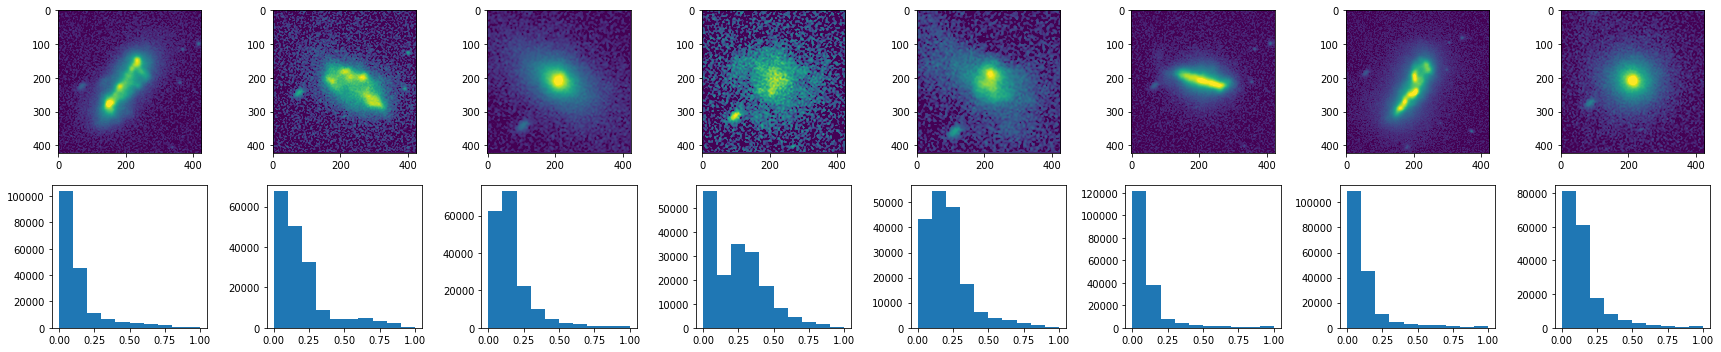

In [72]:
show_images(rescaled_images)  # not masked

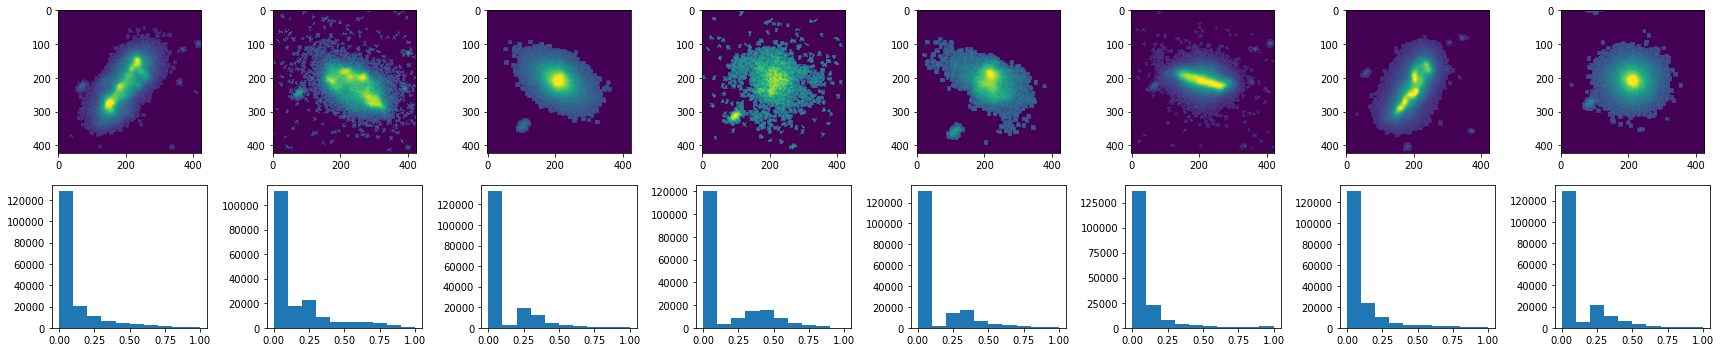

In [69]:
show_images(rescaled_images)  # masked as well

(array([160842.,   7156.,   3683.,   2567.,   2287.,   1428.,    719.,
           396.,    284.,    414.]),
 array([0.        , 0.05873115, 0.11746231, 0.17619346, 0.23492461,
        0.29365577, 0.35238692, 0.41111807, 0.46984923, 0.52858038,
        0.58731154]),
 <a list of 10 Patch objects>)

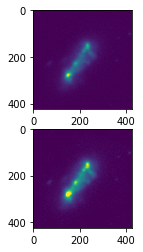

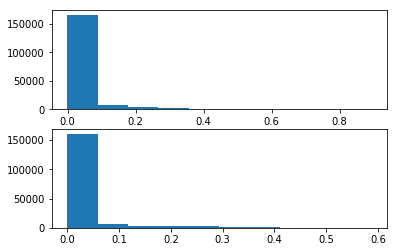

In [40]:
img = raw_images[0]
final_img = clip_img(img)

fig, axes = plt.subplots(nrows=2)
axes[0].imshow(img)
axes[1].imshow(final_img)

fig, axes = plt.subplots(nrows=2)
axes[0].hist(np.ravel(img))
axes[1].hist(np.ravel(final_img))

In [17]:
masked_images = [masked_images[n] for n in range(masked_images.shape[0])]
rescaled_images = list(map(lambda x: np.clip(x, a_min=0, a_max=None), masked_images))
# TODO: clip pixels a given sigma above the others, or clip the brightest n pixels?


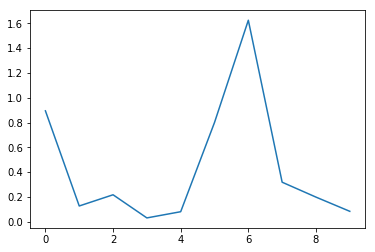

In [31]:
maxima = np.array(list((map(lambda x: np.max(x), rescaled_images))))
plt.plot(maxima[maxima < 100])  # one outlier

(array([1.65402e+05, 6.42700e+03, 3.70700e+03, 2.51000e+03, 8.90000e+02,
        4.58000e+02, 1.77000e+02, 8.40000e+01, 6.30000e+01, 5.80000e+01]),
 array([0.        , 0.0894164 , 0.17883281, 0.26824921, 0.35766561,
        0.44708202, 0.53649842, 0.62591482, 0.71533123, 0.80474763,
        0.89416403]),
 <a list of 10 Patch objects>)

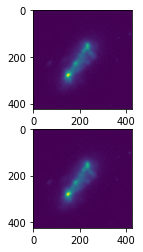

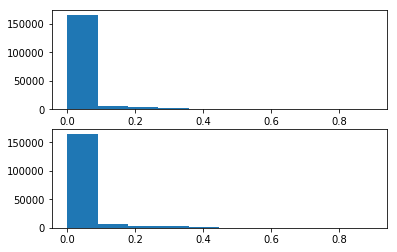

In [36]:
img = rescaled_images[0]
background_mean, background_std = estimate_background(img)
img_clipped = np.clip(img, a_min=0, a_max=background_mean + background_std * 1000)

fig, axes = plt.subplots(nrows=2)
axes[0].imshow(img)
axes[1].imshow(img_clipped)

fig, axes = plt.subplots(nrows=2)
axes[0].hist(np.ravel(img))
axes[1].hist(np.ravel(img_clipped))

(array([1.65261e+05, 6.50400e+03, 3.74300e+03, 2.52300e+03, 9.04000e+02,
        4.56000e+02, 1.79000e+02, 8.40000e+01, 6.40000e+01, 5.80000e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

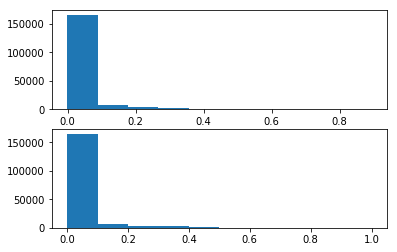

In [26]:

raw_img = raw_images[0]
normed_img = norm(raw_img)
fig, axes = plt.subplots(nrows=2)
axes[0].hist(np.ravel(raw_img))
axes[1].hist(np.ravel(normed_img))

In [20]:
(rescaled_images[0] > 0.5).sum()

542

In [21]:
rescaled_images[0].size

179776

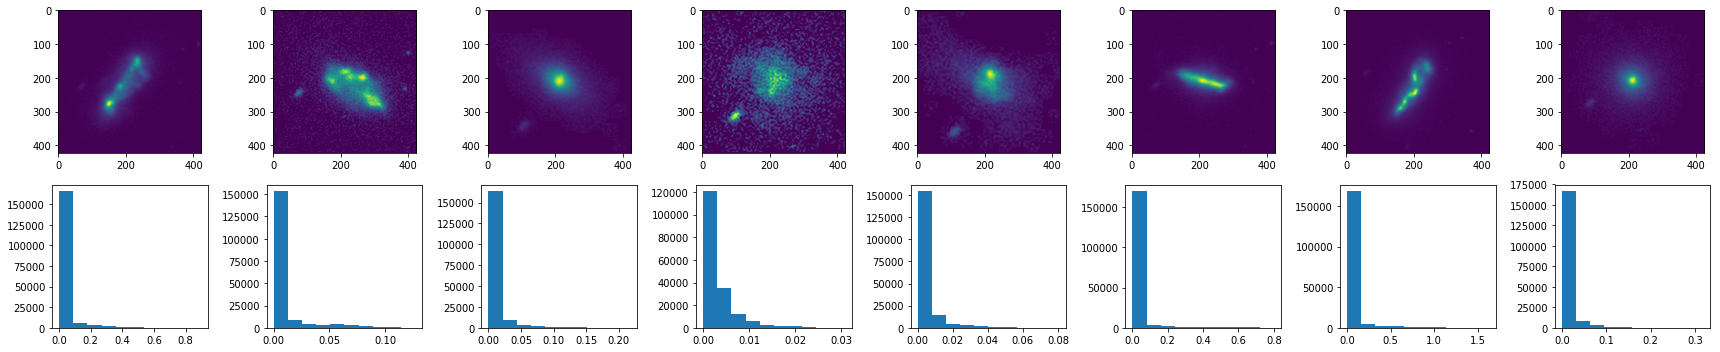

In [22]:
show_images(rescaled_images)

In [23]:
def load_illustris_as_pil(img):  # should be dict with 'fits_loc' component
    img = img - img.min()
    img = img / img.max()
    return Image.fromarray(img * 255)

In [24]:
for img in raw_images[:5]:
    load_illustris_as_pil(img).show()

In [25]:
for img in rescaled_images[:5]:
    load_illustris_as_pil(img).show()